# Load dataset QM9

This is a test script to load and display molecules of the QM9 dataset.

In [4]:
from load_qm9 import qm9_fetch
from display_mol import plot_molecule, plot_multiple_molecules
import matplotlib.pyplot as plt

In [2]:
molecules = qm9_fetch(30)

Archive qm9.tar.bz2 existante

Extraction terminée ! 30 molécules chargées.


In [3]:
print(molecules[0])

{'N': 5, 'elements': [6, 1, 1, 1, 1], 'coords': array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       [-5.40815069e-01,  1.44752661e+00, -8.76643715e-01],
       [-5.23813634e-01,  1.43793264e+00,  9.06397294e-01]]), 'charges': array([-0.535689,  0.133921,  0.133922,  0.133923,  0.133923])}


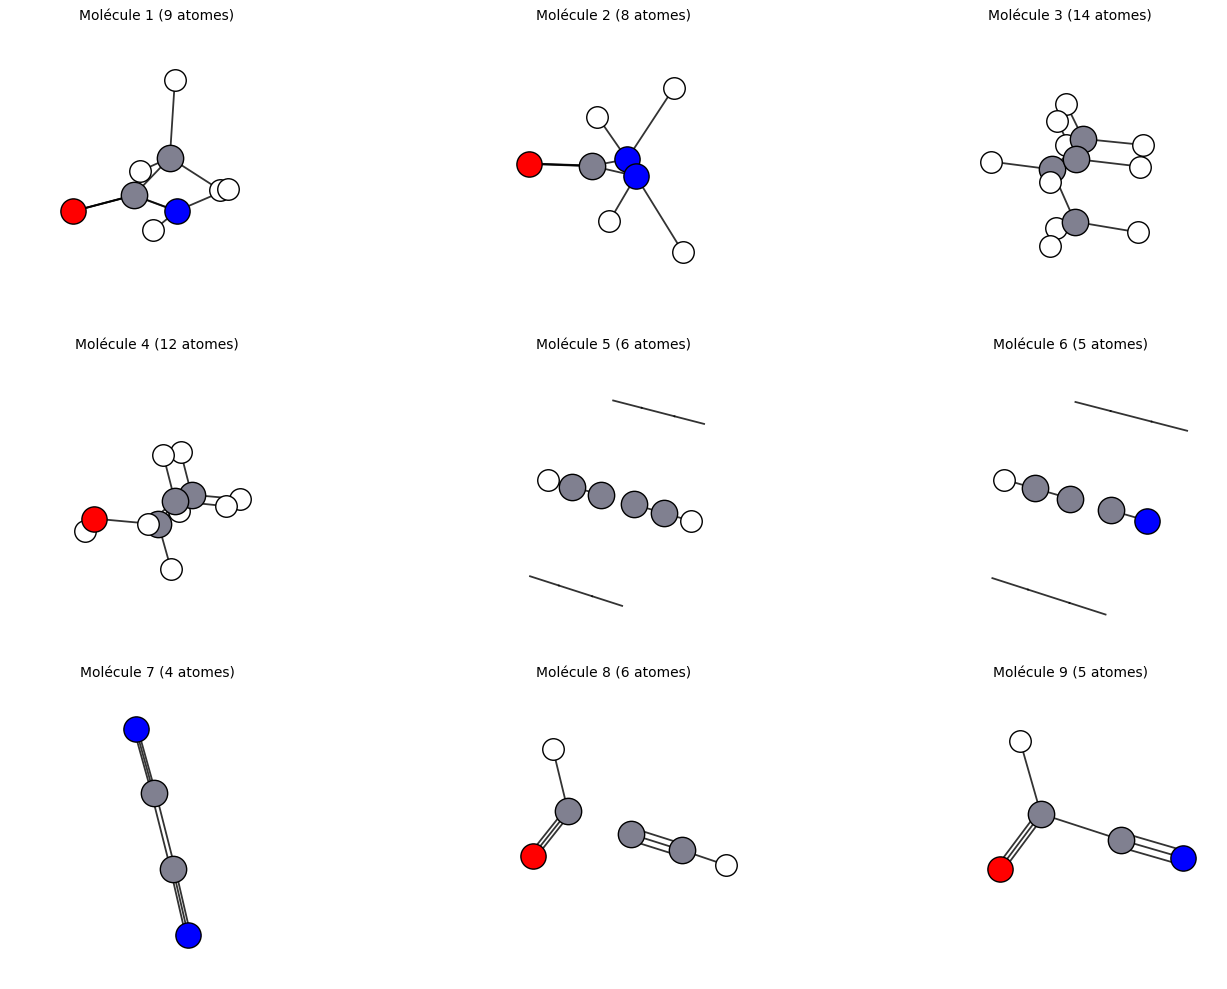

In [5]:


#plot_molecule(molecules[3], title="Première molécule du dataset QM9", show_charges=True) 
plot_multiple_molecules(molecules[18:], 9)
plt.show()
